In [1]:
# Importing the libraries needed
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import logging
logging.basicConfig(level=logging.ERROR)
from torch import cuda
from lib.dataset_utils import *
from lib.plot_utils import *
from lib.scores import *
from lib.models import *
from lib.cross_validation import *
from sklearn.metrics import accuracy_score, jaccard_score, f1_score, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import random

c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:
# Defining some key variables that will be used later on in the training
DATASET = DatasetEnum.GoEmotionsCleaned
DATASET_NAME = 'GoEmotions'
MODEL_NAME = 'Socbert'
CHECKPOINT_DIR = './checkpoints/' + DATASET_NAME + '/'
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
EPOCHS = 4
# Creating the loss function and optimizer
loss_function = torch.nn.BCEWithLogitsLoss()
train_df, val_df, test_df = load_dataset(DATASET)
LABEL_COLS = train_df.columns[1:].tolist()
# scores dictionary
SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}


# Cross Validation
we try to get the best parameters for a bert model on the datacleanedTwitter dataset

In [3]:
params_to_explore = {
    'learning_rate': [5e-05, 2e-05,1e-04],
    'regularization': [0, 1e-05],
    'batch_size': [16],
    'epochs': [EPOCHS],
    'n_classes': [len(LABEL_COLS)],
    'tokenizer_max_len' :[100]
}
RESULT_DIR = './results/' + DATASET_NAME + '/'
RESULT_FILE = RESULT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.csv'
# create the grid search object
grid_search = HoldOutCrossValidation(Socbert, SCORES, train_df, val_df, param_dict=params_to_explore, res_file=RESULT_FILE)
# run the grid search
grid_search.run()

  0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_dow

In [4]:
# load the results
results = grid_search.get_results()
# get the best parameters and scores according to F1 macro
best_info = grid_search.get_best_info('f1_macro')
print("BEST MODEL INFO")
print(best_info)
# print the results
print("RESULTS")
print(results)
print("BEST PARAMS")
BEST_PARAMS = grid_search.get_best_params('f1_macro')
BEST_PARAMS['batch_size'] = int(BEST_PARAMS['batch_size'])
BEST_PARAMS['epochs'] = int(BEST_PARAMS['epochs'])
BEST_PARAMS['n_classes'] = int(BEST_PARAMS['n_classes'])

BEST MODEL INFO
{'batch_size': 16.0, 'epochs': 6.0, 'learning_rate': 2e-05, 'n_classes': 28.0, 'regularization': 1e-05, 'tokenizer_max_len': 100.0, 'train_accuracy': 0.47431467403824, 'train_jaccard_macro': 0.33381545928912537, 'train_f1_macro': 0.4712821434439542, 'train_jaccard_samples': 0.5684058972586963, 'train_f1_micro': 0.6086298258894777, 'train_membership': 0.6433771020502188, 'val_accuracy': 0.4452635458901585, 'val_jaccard_macro': 0.3149663902032099, 'val_f1_macro': 0.4485667492621875, 'val_jaccard_samples': 0.5337541467010689, 'val_f1_micro': 0.5683035031359951, 'val_membership': 0.5978621452266863}
RESULTS
   batch_size  epochs  learning_rate  n_classes  regularization  \
0          16       6        0.00005         28         0.00000   
1          16       6        0.00005         28         0.00001   
2          16       6        0.00002         28         0.00000   
3          16       6        0.00002         28         0.00001   
4          16       6        0.00010  

In [3]:
# Defining some key variables that will be used later on in the training
DATASET = DatasetEnum.GoEmotionsCleaned
DATASET_NAME = 'GoEmotions'
MODEL_NAME = 'SocbertCleaned'
CHECKPOINT_DIR = './checkpoints/' + DATASET_NAME + '/'
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
MINIBATCH_SIZE = 16
EPOCHS = 4
LAMBDA = 1e-05
LEARNING_RATE = 2e-05
# Creating the loss function and optimizer
loss_function = torch.nn.BCEWithLogitsLoss()
train_df, val_df, test_df = load_dataset(DATASET)
LABEL_COLS = train_df.columns[1:].tolist()

In [5]:
# model parameters
PARAMS = {'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':EPOCHS, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':len(LABEL_COLS),
          "tokenizer_max_len" :100}
# scores dictionary
SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}
# creating the 
# we set a seed ti get the sane weight initializzazion for the data prep validation
             

In [6]:
seed_val = 2
random.seed(seed_val)
torch.manual_seed(seed_val)
np.random.seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
model = Socbert(SCORES,
             PARAMS)    
model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=True, checkpoint_path=CHECKPOINT_MODEL_FILE,checkpoint_score="f1_macro",checkpoint_score_maximize=True,shuffle_training=False)

c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 2/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 3/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 4/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

In [ ]:
model = Socbert(SCORES,
                PARAMS,checkpoint=CHECKPOINT_MODEL_FILE) 

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


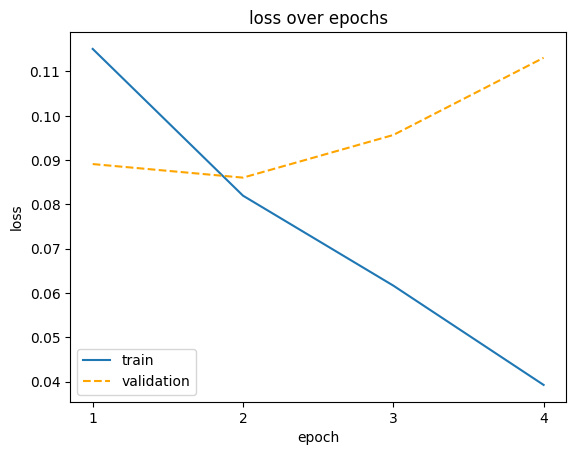

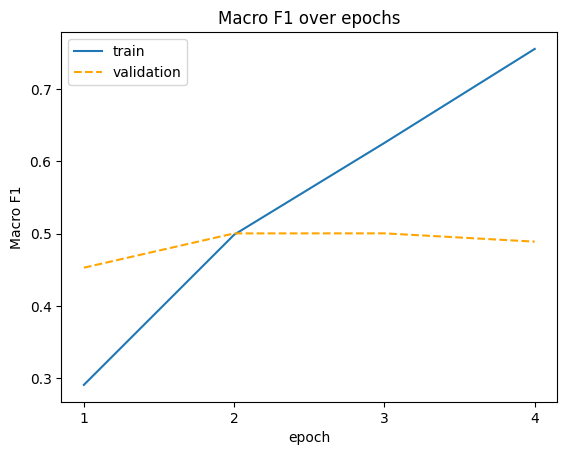

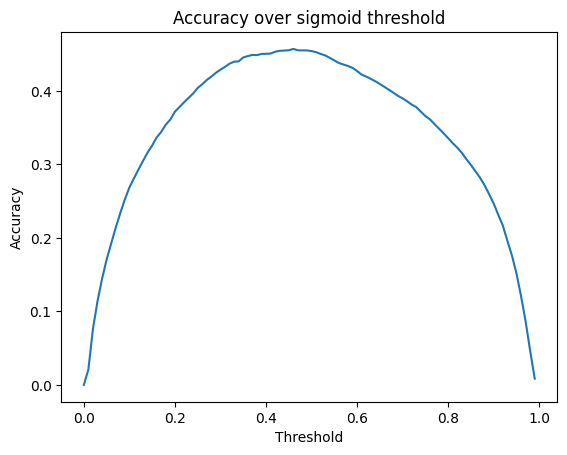

Best threshold: 0.46
Best Accuracy: 0.45705860670844084


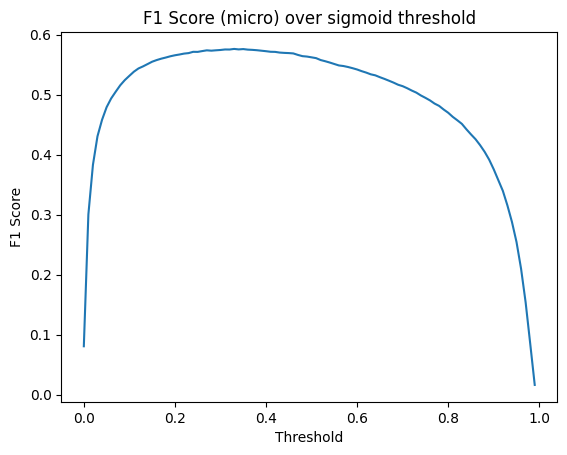

Best threshold: 0.33
Best F1 Score (micro): 0.576347771891555


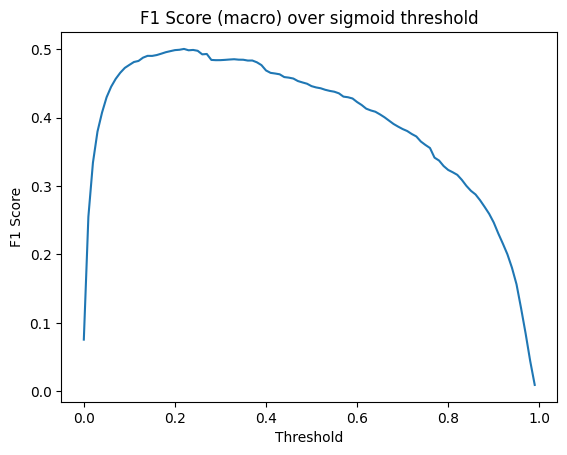

Best threshold: 0.22
Best F1 Score (macro): 0.5004126245884721


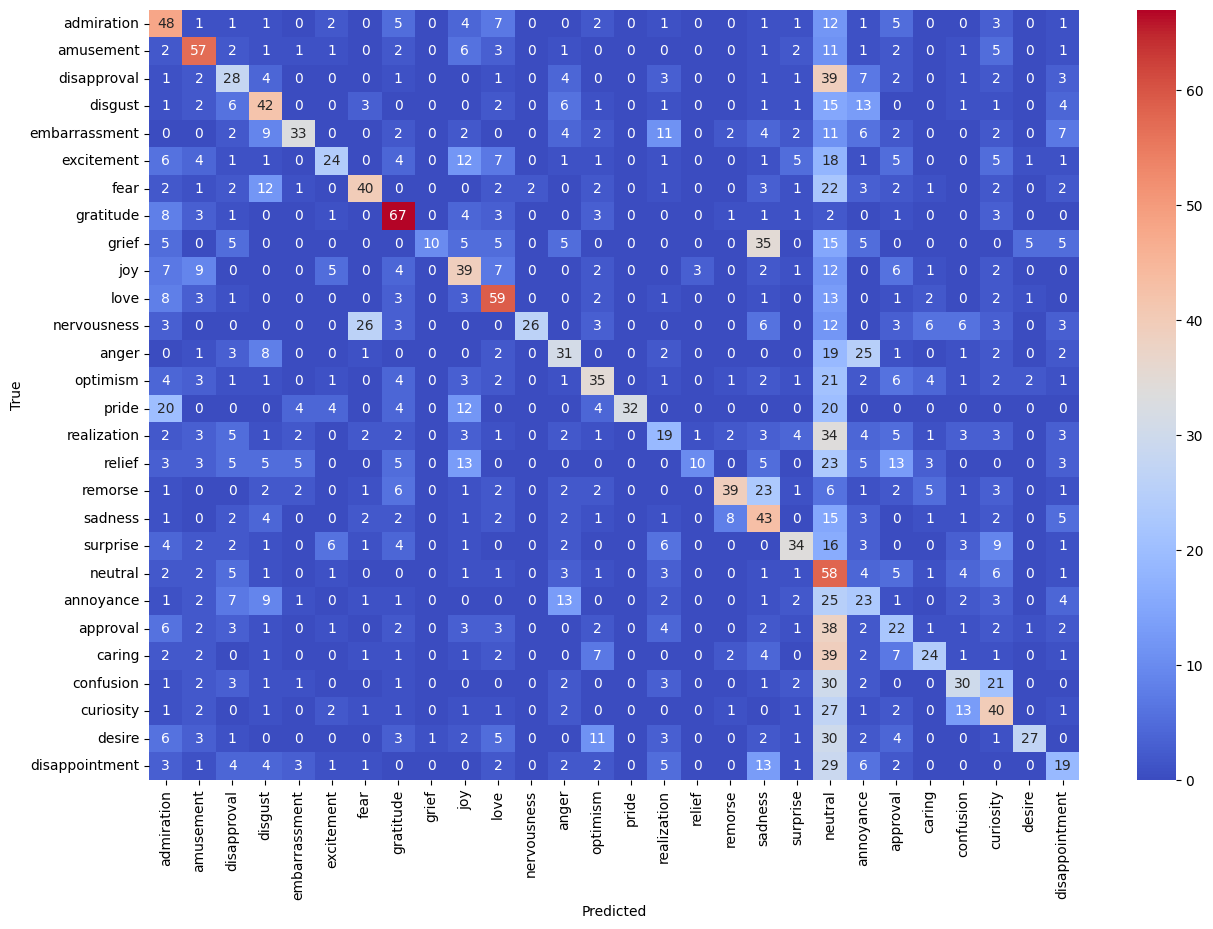

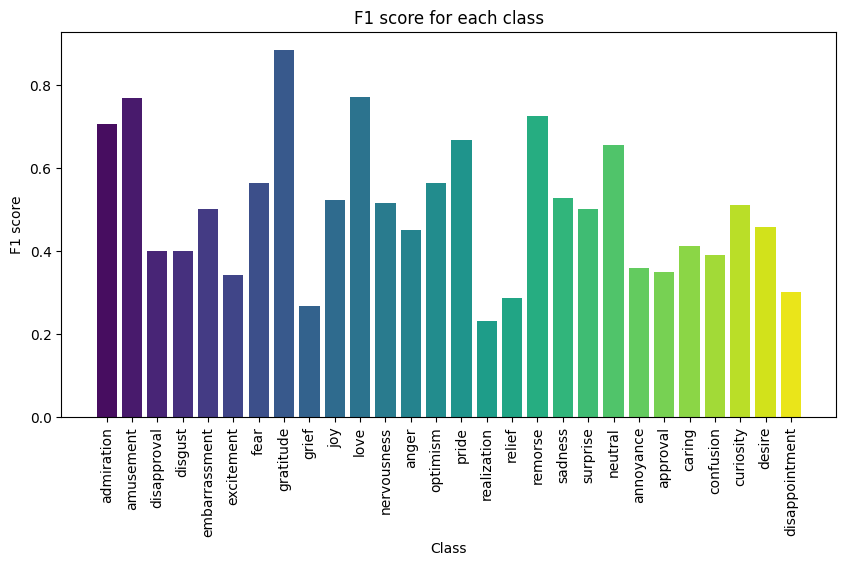

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.72                0.69                0.71                0.54                 488
amusement                           0.72                0.82                0.77                0.62                 303
disapproval                         0.37                0.43                0.40                0.25                 292
disgust                             0.29                0.64                0.40                0.25                  97
embarrassment                       0.49                0.51                0.50                0.33                  35
excitement                          0.33                0.35                0.34                0.21                  96
fear                                0.58                0.54                0.56                0.39                  90
gratitude

In [7]:
model_analysis(model, val_df, LABEL_COLS)

## Goemotions:NoDataCleaning
We try to validate our datacleaning process training a Socbert model with vanilla tr-set

c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 2/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 3/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 4/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Threshold = 0.22


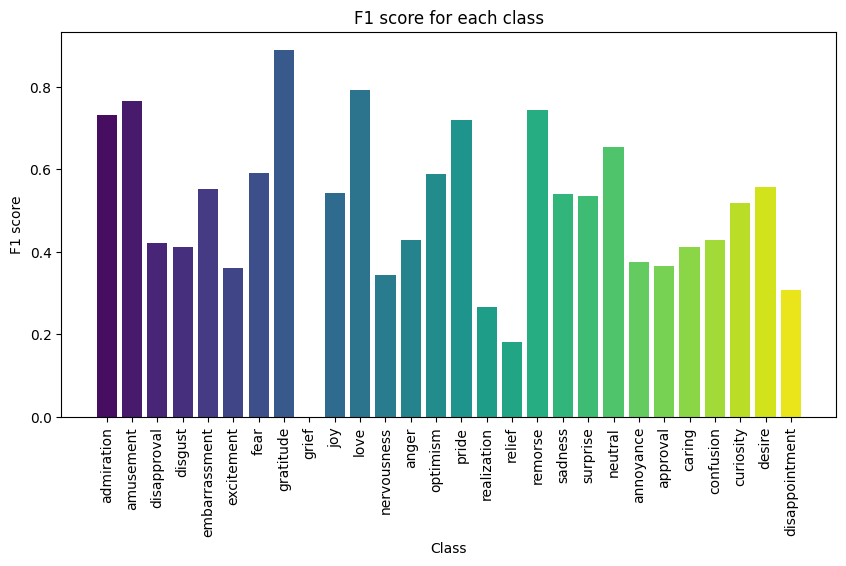

In [4]:
train_df, val_df, test_df = load_dataset(DatasetEnum.GoEmotions, k_hot_encode=True)
MODEL_NAME = 'SocbertUncleaned'
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
PARAMS = {'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':EPOCHS, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':28,
          'tokenizer_max_len' :100,
}

SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}

# creating the model with the same seed as the cleaned version
seed_val = 2
random.seed(seed_val)
torch.manual_seed(seed_val)
np.random.seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
model_uncleaned = Socbert(SCORES,
                PARAMS)    
model_uncleaned.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=True, checkpoint_path=CHECKPOINT_MODEL_FILE,checkpoint_score="f1_macro",checkpoint_score_maximize=True,shuffle_training=False)
out_uncleaned = model_uncleaned.predict(val_df)
target_uncleaned = val_df.iloc[:, 1:].values
thresh_uncleaned, _ = tune_sigmoid_threshold(target_uncleaned, out_uncleaned, metric_params={'average':'macro', 'zero_division':0}, metric_fun=f1_score)
print(f"Threshold = {thresh_uncleaned}")
best_out_uncleaned = (out_uncleaned > thresh_uncleaned).astype(int)
plot_score_barplot(target_uncleaned, best_out_uncleaned, LABEL_COLS)

Now we can compare the graphical results of the obtained models

In [10]:
_,val_df_uncleaned,_ = load_dataset(DatasetEnum.GoEmotions, k_hot_encode=True)
_,val_df,_ = load_dataset(DatasetEnum.GoEmotionsCleaned)
MODEL_NAME = 'SocbertCleaned'
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
PARAMS = {'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':EPOCHS, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':28, 
          'tokenizer_max_len' :100}

SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}

model_cleaned = Socbert(SCORES,
                PARAMS,checkpoint=CHECKPOINT_MODEL_FILE)
out_cleaned = model_cleaned.predict(val_df)
target_cleaned = val_df.iloc[:, 1:].values
thresh_cleaned, _ = tune_sigmoid_threshold(target_cleaned, out_cleaned, metric_params={'average':'macro', 'zero_division':0}, metric_fun=f1_score)


MODEL_NAME = 'SocbertUncleaned'
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
model_uncleaned = Socbert(SCORES,
                PARAMS,checkpoint=CHECKPOINT_MODEL_FILE)


thresh_uncleaned = 0.22
out_uncleaned = model_uncleaned.predict(val_df_uncleaned)
target_uncleaned = val_df_uncleaned.iloc[:, 1:].values
best_out_uncleaned = (out_uncleaned > thresh_uncleaned).astype(int)
   
out_cleaned = model_cleaned.predict(val_df)
target_cleaned = val_df.iloc[:, 1:].values
best_out_cleaned = (out_cleaned > thresh_cleaned).astype(int)


c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


C:\Users\gdema\AppData\Local\Temp\ipykernel_1736\2273644897.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(barplot.get_xticklabels(),


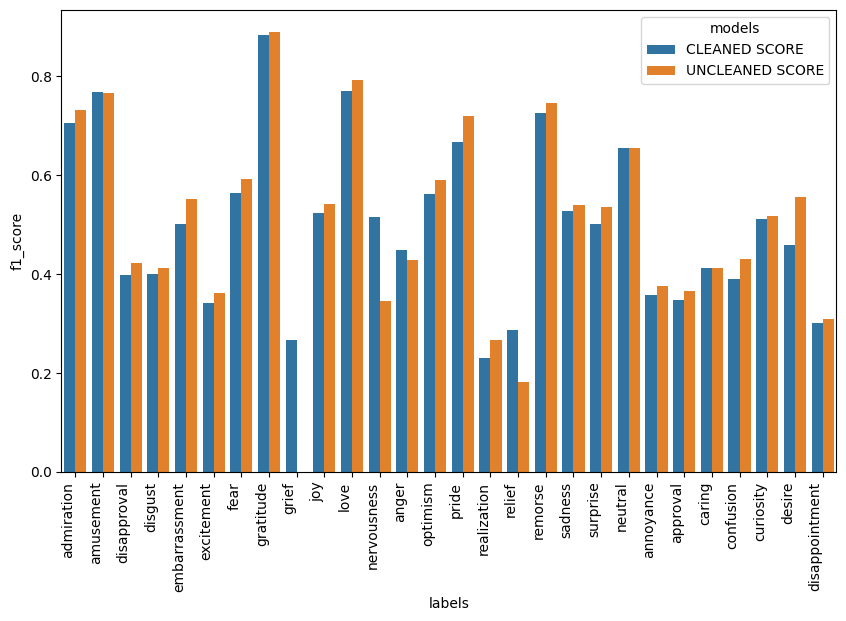

cleaned mean = 0.5004126245884721
uncleaned mean = 0.5010181176137077


In [13]:
cleaned_score = f1_score(target_cleaned, best_out_cleaned,average=None)
uncleaned_score = f1_score(target_uncleaned, best_out_uncleaned,average=None)

# we create a dataframe with for each label the f1 score for both the models
results_df=pd.DataFrame(zip(LABEL_COLS,cleaned_score,uncleaned_score),columns=["labels","CLEANED SCORE","UNCLEANED SCORE"])
results_df = pd.melt(results_df, id_vars="labels", var_name="models", value_name="f1_score")
plt.figure(figsize=(10, 6))
barplot=sns.barplot(x="labels", hue="models", y="f1_score", data=results_df)
barplot.set_xticklabels(barplot.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')
plt.show()

print(f"cleaned mean = {np.mean(cleaned_score)}\nuncleaned mean = {np.mean(uncleaned_score)}")



# GO Emotions: 6 emotions
We can try to map the 27 emtions to Ekman standard and finetune a new model. <br>
We compare mapping first the dataset and then training the model with training the model and mapping the results to get the better alternative

### Mapping post-training
Si riallena il modello fissando il seme per l'inizializzaizone dei pesi


In [4]:
train_df, val_df, test_df = load_dataset(DatasetEnum.GoEmotionsCleaned)

MODEL_NAME = 'Socbert'
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
# creating the model with the same seed as the cleaned version
PARAMS = {'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':4, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':28,
          'tokenizer_max_len' :100,
}

SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}


model = Socbert(SCORES,
                PARAMS) 

model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=True, checkpoint_path=CHECKPOINT_MODEL_FILE,checkpoint_score="f1_macro",checkpoint_score_maximize=True,shuffle_training=True)



c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 2/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 3/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 4/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

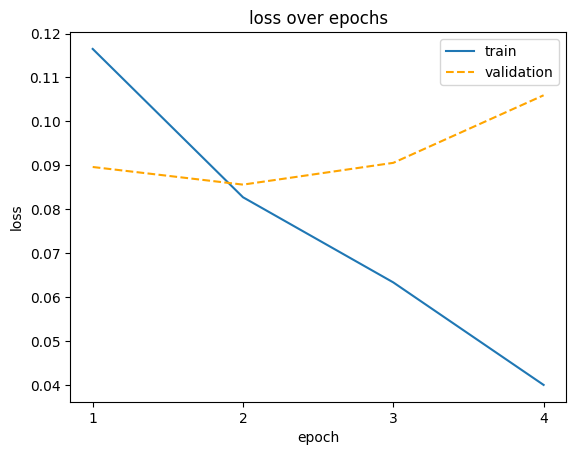

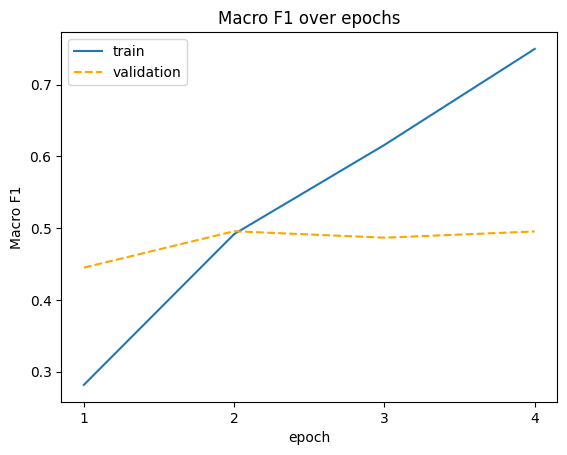

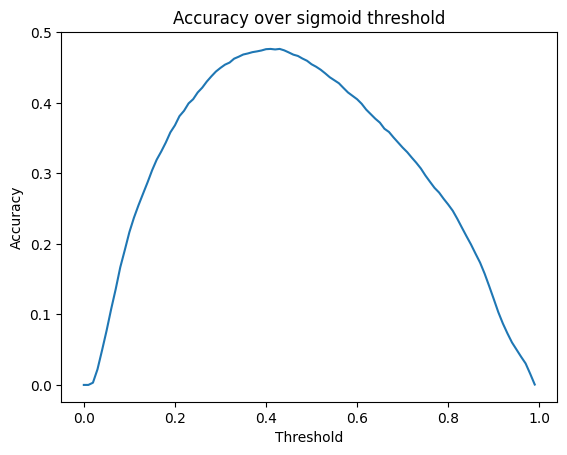

Best threshold: 0.41000000000000003
Best Accuracy: 0.4764098783634353


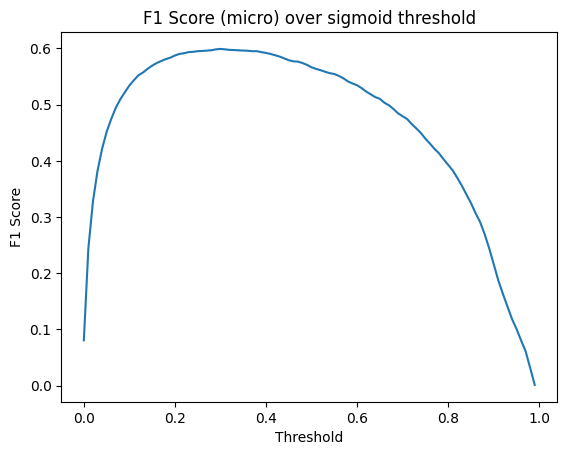

Best threshold: 0.3
Best F1 Score (micro): 0.5990627640777445


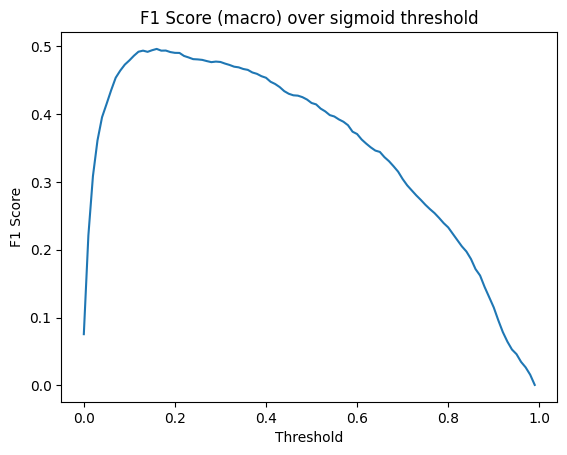

Best threshold: 0.16
Best F1 Score (macro): 0.49573327569193987


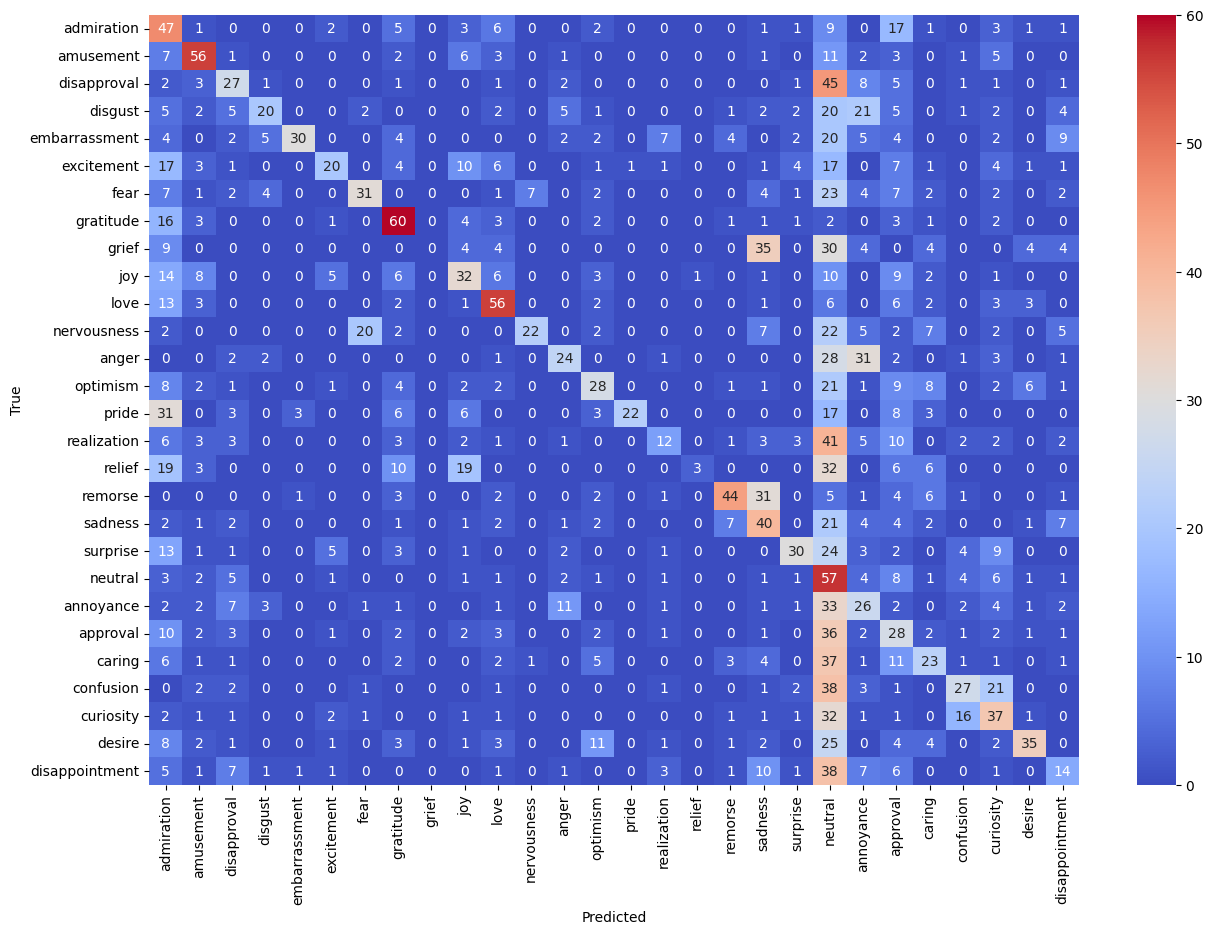

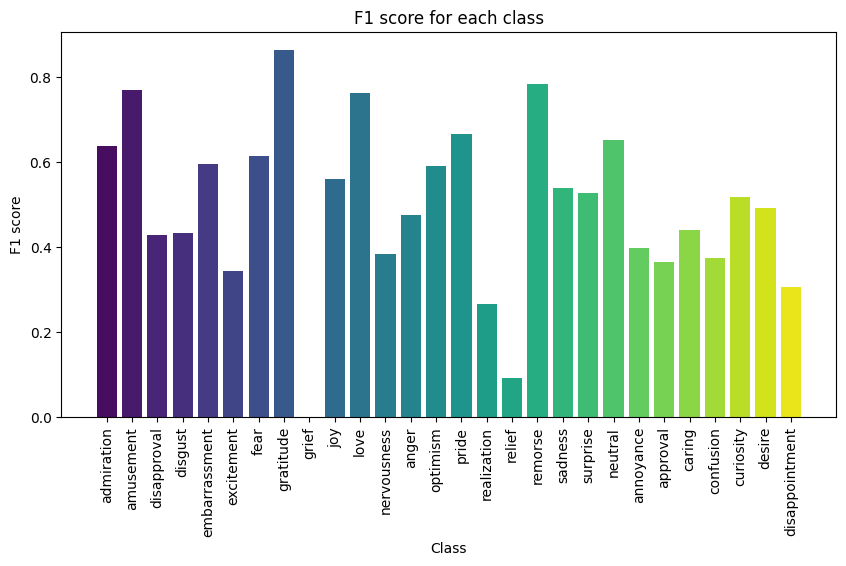

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.51                0.86                0.64                0.47                 488
amusement                           0.69                0.87                0.77                0.63                 303
disapproval                         0.37                0.51                0.43                0.27                 292
disgust                             0.47                0.40                0.43                0.28                  97
embarrassment                       0.77                0.49                0.60                0.42                  35
excitement                          0.31                0.39                0.34                0.21                  96
fear                                0.66                0.58                0.62                0.44                  90
gratitude

In [5]:
model_analysis(model, val_df, LABEL_COLS)

In [6]:
out = model.predict(val_df)
target = val_df.iloc[:, 1:].values
threshold, _ = tune_sigmoid_threshold(target, out, metric_params={'average':'macro', 'zero_division':0}, metric_fun=f1_score)
print(f"Threshold = {threshold}")

#now we predìct to the test values and map the results
#first we map the test set
test_df = goemotions_apply_emotion_mapping(test_df)
EKMAN_LABELS = test_df.columns[test_df.columns.str.startswith('ekman_')].tolist()

out= model.predict(test_df)
target= test_df.iloc[:, 1:].values
best_out = (out> threshold).astype(int)

Threshold = 0.16


Non ho calcolato il post training mapping perchè non interessabte

### Training pre mapping

In [8]:
train_df, val_df, test_df = load_dataset(DatasetEnum.GoEmotionsCleaned)

train_df=goemotions_apply_emotion_mapping(train_df)
val_df=goemotions_apply_emotion_mapping(val_df)
test_df = goemotions_apply_emotion_mapping(test_df)

CHECKPOINT_MODEL_FILE=CHECKPOINT_DIR + 'Socbert_model_preMapTraining.pth'
# creating the model with the same seed as the cleaned version
PARAMS = {'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':4, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':(len(train_df.columns) -1),
          'tokenizer_max_len' :100,
}

SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}


model_preMap = Socbert(SCORES,
                PARAMS) 

model_preMap.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=True, checkpoint_path=CHECKPOINT_MODEL_FILE,checkpoint_score="f1_macro",checkpoint_score_maximize=True,shuffle_training=True)

c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4


  0%|          | 0/1912 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 

In [ ]:
model_analysis(model_preMap, val_df, EKMAN_LABELS)

### Mapping with TwitterData

In [ ]:
DATASET = DatasetEnum.TwitterDataCleaned
MODEL_NAME = 'Bert'
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
train_df, val_df, test_df = load_dataset(DATASET)
TWITTER_LABEL = train_df.columns[1:].tolist()

In [ ]:
PARAMS = {'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':EPOCHS, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':28
}

SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}

# create the model with the best parameters
model = Socbert(SCORES, PARAMS, CHECKPOINT_MODEL_FILE)
# fit the model if checkpoint does not exist
if not os.path.exists(CHECKPOINT_MODEL_FILE):
    model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=False, checkpoint_path=CHECKPOINT_MODEL_FILE, checkpoint_score='f1_macro', checkpoint_score_maximize=True)

In [ ]:
# get model predictions on test set of Twitter dataset
out = model.predict(test_df)
best_out = (out > threshold).astype(int)
# visualize confusion matrix to understand induced mapping
plot_multilabel_confusion_heatmap(test_df[TWITTER_LABEL].values, best_out, TWITTER_LABEL, LABEL_COLS, normalize=True, transpose=True)